In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import torch
import fastai
from fastai import text

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

fastai.core.defaults.device = torch.device(device)

if device == 'cuda':
    text.torch.backends.cudnn.benchmark = True

device: cuda


In [0]:
path = text.untar_data(text.URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [0]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

In [0]:
batch_size = 32

## Language model

In [0]:
data_lm = (text.TextList.from_folder(path)
           # Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           # We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           # We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           # We want to do a language model so we label accordingly
            .databunch(bs = batch_size))

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
data_lm = text.load_data(path, 'data_lm.pkl', bs = batch_size)
data_lm.show_batch()

idx,text
0,"soderbergh 's choices of camera angles , perspective , lighting and all the cinematic aspects give you a permanent first person angle in the action that is so involving that you actually die with xxmaj che in the end of the second movie ... \n \n xxmaj in this sense , also knowing how xxmaj che 's story ends , and regretfully waiting for it to come , proves"
1,", and the biggest mystery ( how he got scar ) is never revealed , only hinted at . xxmaj despite xxmaj joan 's title character and her entrance - making xxmaj jean xxmaj louis wardrobe , this really is an ensemble piece , and everyone does a good solid job in this xxmaj southern xxmaj gothic potboiler . xxmaj the "" town and country "" set of this film"
2,"robert xxmaj richardson and enhanced by a strangely appropriate musical scoring by xxmaj danny xxmaj elfman . xxmaj the film may be about things ugly , but the technique used to tell the story is high quality art . \n \n xxmaj abu xxmaj ghraib , along with xxmaj guantanamo , will always be a scar on the conscience of xxmaj america , even beyond the time that this"
3,"seeing "" xxmaj get xxmaj real "" . xxbos xxmaj make that title about ninety percent nude and ten percent xxmaj satan . xxmaj watching this slice of xxmaj eurotrash , it 's pretty obvious what market the producers were going for . xxmaj so , if you come across this title in the horror section and expect an exciting slash and dice chiller , look elsewhere . xxmaj however"
4,"during the many underwater scenes , and the story often makes little or no sense ( eg . why does xxmaj salas wait for forty years under the lake before emerging ? ) . \n \n xxmaj to be fair , xxmaj yuzna does manage one or two inspired xxunk best being the town 's celebration , which turns into a debauched xxunk with so much mundane drivel between"


In [0]:
learner = text.language_model_learner(data_lm, text.AWD_LSTM, drop_mult=0.5)

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


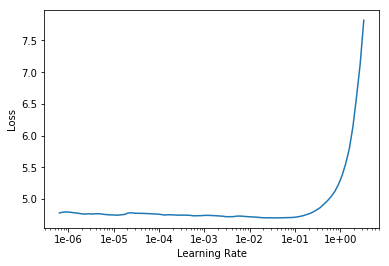

In [0]:
learner.recorder.plot()

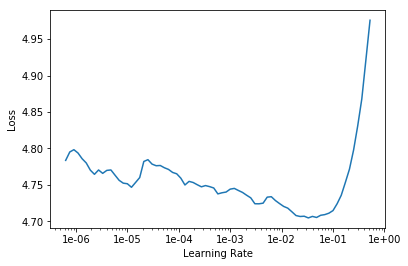

In [0]:
learner.recorder.plot(skip_end=15)

In [0]:
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.338114,4.116738,0.290361,42:57


In [0]:
learner.save('fit_head')

In [0]:
learner.load('fit_head')

In [0]:
learner.unfreeze()

In [0]:
learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

In [0]:
learner.save('fine_tuned')

In [0]:
learner.load('fine_tuned')

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learner.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [0]:
learner.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
data_clas = (text.TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs = batch_size))

data_clas.save('data_clas.pkl')

In [0]:
batch_size = 64
path = text.Path('/root/.fastai/data/imdb/')
path

PosixPath('/root/.fastai/data/imdb')

In [0]:
data_clas = text.load_data(path, 'data_clas.pkl', bs = batch_size)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj okay , so i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games",neg
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",pos
"xxbos i 've rented and watched this movie for the 1st time on xxup dvd without reading any reviews about it . xxmaj so , after 15 minutes of watching i 've noticed that something is wrong with this movie ; it 's xxup terrible ! i mean , in the trailers it looked scary and serious ! \n \n i think that xxmaj eli xxmaj roth ( xxmaj",neg


In [0]:
learner = text.text_classifier_learner(data_clas, text.AWD_LSTM, drop_mult=0.4)

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


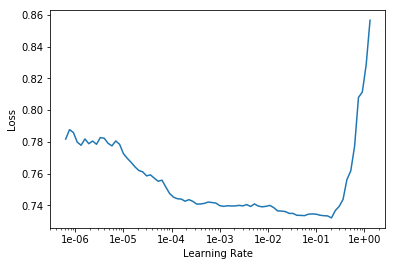

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(2, slice(1e-5, 2e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.695231,0.677556,0.674720,04:41
1,0.691222,0.697524,0.429800,04:46


In [0]:
learner.unfreeze()

In [0]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


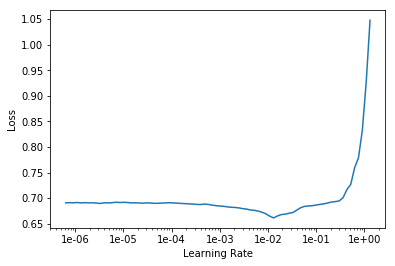

In [0]:
learner.recorder.plot()

In [0]:
learner.fit_one_cycle(10, slice(1e-5, 2e-2), moms=(0.8,0.7))

In [0]:
learner.save('sentiment_classifier')

In [0]:
learner.load('sentiment_classifier')